In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import tensor
from torch.nn import Linear,ReLU,Sigmoid
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
import warnings;warnings.simplefilter('ignore')
import os
os.listdir('../data/P1_data')

['test_170.csv', 'train_4565.csv']

In [2]:
df = pd.read_csv('../data/P1_data/train_4565.csv',index_col=0)

In [3]:
df.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,...,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
2,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,...,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
3,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,...,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
4,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,...,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
5,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,...,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
6,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,...,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# COLUMNS

In [4]:
x_col = df.columns.tolist()[:4]
y_col = df.columns.tolist()[4:]
print(len(x_col))
print(len(y_col))

4
23


# focus

In [5]:
df.columns

Index(['T10', 'T50', 'T90', 'N+A', 'C5NP', 'C5IP', 'C5N', 'C6NP', 'C6IP',
       'C6N', 'C6A', 'C7NP', 'C7IP', 'C7N', 'C7A', 'C8NP', 'C8IP', 'C8N',
       'C8A', 'C9NP', 'C9IP', 'C9N', 'C9A', 'C10NP', 'C10IP', 'C10N', 'C10A'],
      dtype='object')

In [6]:
focus_col = ['C5N',
             'C6N','C6A',
             'C7N','C7A',
             'C8N','C8A',
             'C9N','C9A',
             'C10N','C10A']
focus_idx = []
for i in focus_col:
    focus_idx.append(df.columns.tolist().index(i) - 4)
focus_idx

[2, 5, 6, 9, 10, 13, 14, 17, 18, 21, 22]

# SCALE

In [7]:
ss = StandardScaler()
df[x_col] = ss.fit_transform(df[x_col])
df.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,...,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
2,0.431894,0.537538,0.457373,-1.025830,0.272,0.132,0.059,5.293,2.570,2.819,...,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
3,0.350890,0.336746,0.226896,-1.075101,0.297,0.151,0.062,5.089,2.531,2.804,...,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
4,0.386892,0.475756,0.249944,-1.102020,0.262,0.126,0.061,5.107,2.571,2.771,...,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
5,0.422893,0.444864,-0.372346,-1.088921,0.224,0.105,0.060,4.894,2.497,2.650,...,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
6,0.422893,0.367637,-0.533680,-1.000353,0.243,0.117,0.061,4.946,2.503,2.695,...,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# data_iter

In [8]:
X_train = torch.tensor(df[x_col].to_numpy(),dtype=torch.float)
Y_train = torch.tensor(df[y_col].to_numpy(),dtype=torch.float)
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=128, shuffle=True)

# Construct the neural network

In [9]:
def build_net(input_shape,output_shape):
    net = torch.nn.Sequential(
        Linear(input_shape,128),ReLU(),
        Linear(128,128),ReLU(),
        Linear(128,output_shape),
      )
    return net

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0)
        print('initialize ok')

net = build_net(4,23)
net.apply(init_weights)

initialize ok
initialize ok
initialize ok


Sequential(
  (0): Linear(in_features=4, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=23, bias=True)
)

# optimizer

In [10]:
optimizer = optim.Adam(net.parameters(),lr=0.01)

# obj_function

In [11]:
def obj_function(y_pred,y_real):
    n = y_real.shape[0]
    N_A_pred = y_pred[:,focus_idx].sum(axis=1)
    N_A_real = y_real[:,focus_idx].sum(axis=1)
    # MSE LOSS
    term1 = ((y_pred - y_real)**2).sum() / n
    # N+A LOSS
    term2 = ((N_A_pred - N_A_real)**2).sum() / n
    
    return term1 + 2*term2

# train

In [12]:
def train(net,train_iter,obj_function,optimizer,num_epochs=50):
    history = []
    for epoch in range(num_epochs):    
        for x,y in train_iter:
            loss = obj_function(net(x),y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print("epochs {} loss {:.4f}".format(epoch,loss.item()))
        history.append(loss.item())
    plt.plot(np.array(history))
    plt.title('train loss')
    return net

epochs 0 loss 108.9113
epochs 1 loss 42.5906
epochs 2 loss 15.8524
epochs 3 loss 30.2520
epochs 4 loss 34.6598
epochs 5 loss 10.9876
epochs 6 loss 7.4496
epochs 7 loss 20.9437
epochs 8 loss 16.5161
epochs 9 loss 14.0201
epochs 10 loss 12.2778
epochs 11 loss 39.9118
epochs 12 loss 25.6251
epochs 13 loss 17.5591
epochs 14 loss 16.4441
epochs 15 loss 7.4835
epochs 16 loss 19.3617
epochs 17 loss 13.9634
epochs 18 loss 17.7698
epochs 19 loss 14.3898
epochs 20 loss 22.4695
epochs 21 loss 7.7430
epochs 22 loss 11.9610
epochs 23 loss 12.4234
epochs 24 loss 12.3815
epochs 25 loss 7.4139
epochs 26 loss 12.1246
epochs 27 loss 27.2683
epochs 28 loss 8.8115
epochs 29 loss 15.8291
epochs 30 loss 8.5848
epochs 31 loss 6.0379
epochs 32 loss 6.2846
epochs 33 loss 11.6924
epochs 34 loss 31.3449
epochs 35 loss 10.9402
epochs 36 loss 9.0085
epochs 37 loss 7.7259
epochs 38 loss 9.0924
epochs 39 loss 22.3174
epochs 40 loss 11.8465
epochs 41 loss 4.3503
epochs 42 loss 15.3204
epochs 43 loss 6.4547
epochs 44 

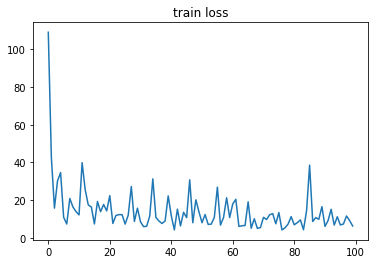

In [13]:
net = train(net,train_iter,obj_function,optimizer,num_epochs=100)

# metric

In [14]:
# load test data
test = pd.read_csv('../data/P1_data/test_170.csv',index_col=0)
test[x_col] = ss.transform(test[x_col])
X_test = torch.tensor(test[x_col].to_numpy(),dtype=torch.float)
Y_test = torch.tensor(test[y_col].to_numpy(),dtype=torch.float)

In [15]:
# pred
y_pred = pd.DataFrame(net(X_test).detach().numpy(),columns=y_col)
y_real = pd.DataFrame(Y_test.detach().numpy(),columns=y_col)

In [16]:
# result
res = pd.DataFrame(index=y_col,columns=['R2','RMSE'])
for i in y_col:
    res.loc[i,'R2'] = max(r2_score(y_real[i],y_pred[i]),0)
    res.loc[i,'RMSE'] = sqrt(mean_squared_error(y_real[i],y_pred[i]))
res.loc['AVG'] = res.mean(axis=0)
res

,R2,RMSE
C5NP,0.908679,0.25825
C5IP,0.802334,0.227511
C5N,0.914585,0.0400094
C6NP,0.05573,0.393142
C6IP,0.890456,0.345955
C6N,0.914747,0.483531
C6A,0,0.400033
C7NP,0.985245,0.267146
C7IP,0.892274,0.36268
C7N,0.974509,0.665359


In [17]:
# N+A SUM
y_pred_NaddA = y_pred.iloc[:,focus_idx].sum(axis=1)
y_real_NaddA = y_real.iloc[:,focus_idx].sum(axis=1)

In [18]:
res2 = pd.DataFrame(index=['N+A'],columns=['R2','RMSE'])
res2.loc['N+A','R2'] = r2_score(y_real_NaddA,y_pred_NaddA)
res2.loc['N+A','RMSE'] = sqrt(mean_squared_error(y_real_NaddA,y_pred_NaddA))
res2

,R2,RMSE
N+A,0.999744,0.131971


In [19]:
pd.concat([y_pred_NaddA,y_real_NaddA],axis=1)

,0,1
0,40.058697,40.132999
1,32.130127,32.174999
2,31.411346,31.427998
3,31.379313,31.389997
4,32.379406,32.417999
...,...,...
165,53.788059,53.841000
166,53.296818,53.442001
167,52.353889,52.549004
168,49.679417,49.827003
